<img src='https://user-images.githubusercontent.com/6457691/90080969-0f758d00-dd47-11ea-8191-fa12fd2054a7.png' width = '200' align = 'right'>

## *DATA SCIENCE / SECTION 4 / SPRINT 3 / NOTE 4*

--- 
#  Generative Adversarial Networks, GAN

# WarmUp
- 오늘 강의 [10분 미리보기](https://www.youtube.com/watch?v=N9ewzLUZhL8) 
- 오늘 배울 것을 미리 보는 [DCGAN](https://www.youtube.com/watch?v=EYrt7fGyA08)
- 실무에서 자주 사용하는 [Conditional GAN](https://www.youtube.com/watch?v=iCgT8G4PkqI) 
- 다양한 [GAN 모델](https://ysbsb.github.io/gan/2020/06/17/GAN-newbie-guide.html) 미리보기

# 🏆 학습목표
- GAN의 대립적인 의미를 이해한다. 
- DCGAN의 Latent 개념과 그 연산에 대해서 이해한다. 
- CycleGAN의 개념을 이해한다. 

이번시간에는 Convolution Neural Network(CNN)을 기반으로한 생성모델인 Deep Convolutional GAN (DCGAN)부터 시작하여, CycleGAN까지의 확장에 대해서 공부해보겠습니다. 최근들어 음성합성기술과 동시에 얼굴을 합성하는 기술인 DeepFake 등 가짜뉴스를 만들어내는 사회적 이슈가 떠오르고 있습니다. 이 이슈의 사용된 기술인 이미지를 생성할 수 있는 기술인 GAN에 대해서 알아보면서 생성모델에 대해서 공부해보고, 어떤 원리로 동작하는 지 알아보겠습니다. CNN의 가장 기본적인 예제로 가장 많이 사용하던 MNIST Dataset을 생성해보고, 조금 더 발전된 이미지로 확장해보겠습니다. 예제 코드는 [케라스 Sequential API](https://www.tensorflow.org/guide/keras)와 `tf.GradientTape` 훈련 루프를 사용하여 작성했습니다.

## 생성적 대립 신경망(GANs)은 무엇인가요? 

[생성적 대립 신경망](https://arxiv.org/abs/1406.2661) (Generative Adversarial Networks, GANs)은 요즘 컴퓨터 과학에서 가장 흥미로운 아이디어 중 하나입니다. 발음은 [갠], [간]으로 대부분 읽으십니다. CNN의 대부 `Yann Lecun`은 `Ian Goodfellow`가 개발한 `GAN`을 보며, "지금까지 머신러닝이 하지 못했던 것들을 잘, 멋지게, 그리고 그럴 듯하게 창조해 내는 것"이라며 찬사를 아끼지 않았고, 2016-2019년에는 GAN관련된 논문들이 학회를 도배합니다.

`GAN의 원리`는 간단합니다. 골키퍼 야신, 카시아스, 알리송 베커 같은 유명한 골키퍼 앞에서 패널트킥 연습을 엄청 하게해서 골을 넣기 시작했다면, "패널트킥 슛팅"하는 기술이 금새 늘어나는 원리입니다. 생성모델(슈터)과 판별모델(골키퍼) 두 모델이 대립적인 과정을 통해 동시에 훈련됩니다. 초반에는 역시 골키퍼가 잘합니다. 왜냐면 월드클래스(Pre-trained)의 골키퍼를 데려다가 시작하기 때문입니다. 

개념의 이해를 위해서 전통적인 설명을 추가하면, **위조지폐**에 대해서 얘기를 해보겠습니다. 위조지폐를 만들려는 "위조지폐범"이 지폐를 위조하지 못하게하고, 또 위조지폐와 진폐를 잘 가려내고 싶은 "조폐공사"가 있다고 합시다. 조폐공사에서는 위폐를 감별하는 기술을 지폐에 적용해야 합니다. 반대로 위조지폐범은 감별하는 기술에 걸리지 않는 위조지폐를 만들려고 기술을 발전시킵니다. 서로의 정보를 참고해서 기술이 발달되기 때문에 지폐를 제작하는 기술이 점점 좋아지게 됩니다. 그럼 더욱 정교한 위조지폐를 만들 수 있게 됩니다. 이런 원리입니다. 

이 원리를 "인공지능 화가"제작에 적용해보면, **Creator/Generator** ("AI화가")는 진짜 작품처럼 보이는 이미지를 생성하도록 배우게 되고, 동시에 **Descriminator** ("AI감별사")는 인공지능이 만든 가짜의 이미지들과 진짜를 예술작품을 구별하게 되는 것을 배우게 되는 원리입니다.

![생성자와 감별자를 그린 도표](https://tensorflow.org/tutorials/generative/images/gan1.png)


훈련과정 동안 **Generator**는 점차 실제같은 이미지를 더 잘 생성하게 되고, **Descriminator**는 점차 진짜와 가짜를 더 잘 구별하게됩니다. 이 과정은 **Descriminator**가 가짜 이미지에서 진짜 이미지를 더이상 구별하지 못하게 될때, 평형상태에 도달하게 됩니다. 

![생성자와 감별자를 그린 두번째 도표](https://tensorflow.org/tutorials/generative/images/gan2.png)

이 실습을 MNIST 데이터를 이용하여 시작해보겠습니다. 아래의 애니메이션은 50 에포크(epoch)동안 훈련한 **Generator**가 생성해낸 연속된 이미지들을 보여줍니다. 이미지들은 랜덤한 잡음으로 부터 시작되었고, 점차 시간이 지남에 따라 손으로 쓴 숫자들을 닮아가게 됩니다.

![출력 예시](https://tensorflow.org/images/gan/dcgan.gif)

생성적 대립 신경망 (GANs)에 대해 더 배우고 싶으시다면, MIT의 [Intro to Deep Learning](http://introtodeeplearning.com/) 수업을 추천합니다.

실습을 하기 전에 네트워크 구조를 한번 살펴보겠습니다. 

이제 이런 그림을 보면, 네트워크가 들어간 이미지들이 어떤 식으로 흘러갈 지 감이 오실거에요, autuencoder를 중심부터 바깥쪽으로 뒤집어 둔 개념이라고 보시면 될 것 같습니다.

<img src="https://gluon.mxnet.io/_images/dcgan.png"/>

### 텐서플로와 다른 라이브러리 불러오기

In [ ]:
# !pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 44kB/s 
     |████████████████████████████████| 501kB 60.8MB/s 
     |████████████████████████████████| 4.3MB 51.7MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.0.0-rc1'

In [ ]:
# GIF를 만들기위해 설치합니다.
!pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### 데이터셋 로딩 및 준비
생성자와 감별자를 훈련하기위해 MNIST 데이터셋을 사용할것입니다. 생성자는 손글씨 숫자 데이터를 닮은 숫자들을 생성할 것입니다. 

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## DCGAN 모델 만들기 
생성자와 감별자는 [케라스 Sequential API](https://www.tensorflow.org/guide/keras#sequential_model)를 이용해 만들 수 있습니다.

### 생성자 (Generator)

생성자는 시드값 (seed; 랜덤한 잡음)으로부터 이미지를 생성하기 위해, `tf.keras.layers.Conv2DTranspose` (업샘플링) 층을 이용합니다. 처음 `Dense`층은 이 시드값을 인풋으로 받습니다. 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 업샘플링을 여러번 합니다. tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 `tf.keras.layers.LeakyReLU`을 사용하고 있음을 주목합시다.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

(아직 훈련이 되지않은) 생성자를 이용해 이미지를 생성해봅시다. 

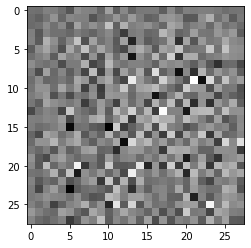

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 감별자 (Discriminator)
감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기입니다. 

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

(아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별합니다. 모델은 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련되어집니다.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0040179]], shape=(1, 1), dtype=float32)


## 손실함수와 옵티마이저 정의
두 모델의 손실함수와 옵티마이저를 정의합니다. 

In [ ]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 감별자 손실함수

이 메서드는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. <br>진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 생성자 손실함수

생성자의 손실함수는 감별자를 얼마나 잘 속였는지에 대해 수치화를 합니다. 직관적으로 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 여기서 우리는 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교를 할 것입니다. 

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

감별자와 생성자는 따로 훈련되기 때문에, 감별자와 생성자의 옵티마이저는 다르게 설정해줍니다.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 체크포인트 저장
오랜 시간 진행되는 훈련이 방해되는 경우에 유용하게 쓰일 수 있도록 학습 중간에 모델의 저장방법과 복구방법을 보여줍니다. 

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 훈련 루프 정의하기

훈련 루프는 생성자가 입력으로 랜덤시드를 받는 것으로부터 시작됩니다. 그 시드값을 사용하여 이미지를 생성합니다. 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (생성자가 생성해낸) 가짜이미지를 분류합니다. 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 생성자와 감별자를 업데이트합니다.

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# `tf.function`이 어떻게 사용되는지 꼭 확인하세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**이미지 생성 및 저장**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### 모델 훈련
위에 정의된 `train()` 메서드를 생성자와 감별자를 동시에 훈련하기 위해 호출합니다. 생성적 대립 신경망을 학습하는 것은 매우 까다로울 수 있습니다. 생성자와 감별자가 서로를 제압하지 않는 것이 중요합니다. (예를 들어 학습률이 비슷하면 한쪽이 우세해집니다.)
훈련 초반부에는 생성된 이미지는 랜덤한 노이즈처럼 보입니다. 훈련이 진행될수록, 생성된 숫자는 점차 진짜처럼 보일 것입니다. 약 50 에포크가 지난 후, MNIST 숫자와 닮은 이미지가 생성됩니다. 코랩에서 기본 설정으로 실행하면, 에포크마다 1분정도 소요될 것입니다.

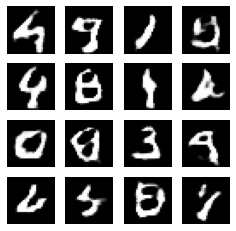

CPU times: user 2min 9s, sys: 21.7 s, total: 2min 31s
Wall time: 9min 29s


In [ ]:
%%time
train(train_dataset, EPOCHS)

마지막 체크포인트를 복구합니다.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### GIF 생성

In [ ]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

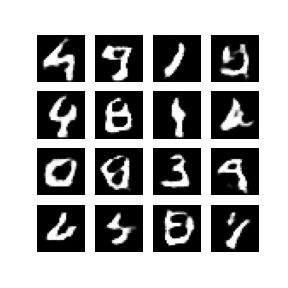

In [ ]:
display_image(EPOCHS)

`imageio`로 훈련 중에 저장된 이미지를 사용해 GIF 애니메이션을 만듭니다.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

코랩에서 작업하고 있다면, 아래의 코드에서 애니메이션을 다운로드 받을 수 있습니다: 

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

위의 작업을 이미지로 해본다면 다음과 같은 결과를 얻을 수 있습니다. 
해당 내용은 과제를 통해서 알아보겠습니다. 

To be Continue!

<img src="https://miro.medium.com/max/884/1*e4kDgDoneKl1M98rG-n4PQ.png"/>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip freeze > "drive/MyDrive/Colab Notebooks/section4/N434_1_requirements.txt"

In [ ]:
!ls "drive/MyDrive/Colab Notebooks/section4/"

# CycleGAN

위에서 배운 DCGAM의 구조를 변경해서 새로운 아키텍쳐를 생성하였습니다. 이번에는 쌍을 이루는 이미지같은 것을 보실 수 있는데, 굳이 쌍이 없더라도 학습과 테스트를 해볼 수 있도록 만들어진 것이 해당 논문의 핵심이었습니다. 페어링되지 않은 이미지 대 이미지 변환을 보여줍니다. 이 논문은 한 이미지 도메인의 특성(얼룩줄무늬)을 캡처하고 이러한 특성을 다른 이미지 도메인(말, horse)으로 변환 할 수있는 방법을 알아낼 수 있는 방법을 제안합니다.

논문의 메인 이미지를 보시면, CycleGAN이라고도 알려진 Cycle-Consistent Adversarial Networks를 사용한 예시를 보실 수 있습니다.  
- 그림 vs 사진
- 얼룩말 vs 말
- 여름 vs 겨울
- 화가 변환

<img src="https://postfiles.pstatic.net/MjAyMDExMjNfMTQy/MDAxNjA2MTA0MzQ1MTQ4.IV256gnjP2w3elW23Bt2OA2Cb2lcjVosDy-LD7XhtU0g.wNfldsfrL99Cw3rpubJZzXk6fxlDYf3JXhV3o-GAgEUg.PNG.tlqordl89/image.png?type=w773" width=1200/>

이 예제는 [Pix2Pix 튜토리얼](https://www.tensorflow.org/tutorials/generative/pix2pix)에서 사용하는 기반 기술을 이용하여 제작하였습니다. CycleGAN의 코드는 유사하며 주요 차이점은 추가 손실 함수와 페어링되지 않은 훈련 데이터의 사용입니다.

CycleGAN은 주기 일관성 손실을 사용하여 쌍을 이루는 데이터 없이도 훈련을 가능하게 합니다. 즉, 소스 및 대상 도메인 간의 일대일 매핑없이 한 도메인에서 다른 도메인으로 변환 할 수 있습니다.

이것은 [해상도향상](https://jonathan-hui.medium.com/gan-super-resolution-gan-srgan-b471da7270ec), 사진의 그림화, [스타일 변환](https://blog.naver.com/PostView.nhn?blogId=tlqordl89&logNo=221536378926&parentCategoryNo=&categoryNo=20&viewDate=&isShowPopularPosts=true&from=search) 등과 같은 많은 흥미로운 작업을 수행 할 수있는 가능성을 열어줍니다. 필요한 것은 소스와 대상 데이터 세트 (단순히 이미지 디렉토리)뿐입니다. 사진을 화가의 그림처럼 바꿔주는 기술은 전시회나 미술관에 다녀오신 분들이라면 한번씩 보셨을 것입니다.

한편 과일의 종류를 바꾸는 예시도 있으며, 

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-Object-Transfiguration-from-Apples-to-Oranges-and-Oranges-to-Apples.png" width=800/>

사진 속 계절을 변경하는 것도 가능합니다. 
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-Season-Transfer-from-Winter-to-Summer-and-Summer-to-Winter.png" width=800/>

### 예제 불러오기
놀라움은 잠시 뒤로하고 가장 기본적인 예시를 통해서 실습을 해보겠습니다. 

생성기와 판별 자를 가져올 수있는 tensorflow_examples 패키지를 설치합니다.

In [ ]:
import urllib.request
urllib.request.urlretrieve('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/note433/requirements.txt', 'GANrequirements.txt')
!ls

GANrequirements.txt  sample_data


In [ ]:
!pip install -r GANrequirements.txt

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE

## Input Pipeline
이 튜토리얼은 말 이미지에서 얼룩말 이미지로 변환하는 모델을 학습시킵니다. 이 데이터 세트 및 유사한 데이터 세트는 [여기](https://www.tensorflow.org/datasets/datasets#cycle_gan). 에서 찾을 수 있습니다.

[paper](https://arxiv.org/abs/1703.10593) 에서 언급했듯이 훈련 데이터 세트에 무작위 지 터링 및 미러링을 적용합니다. 이들은 과적 합을 방지하는 이미지 확대 기술 중 일부입니다.

이것은 [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset) 에서 한 것과 유사합니다

무작위 지 터링에서 이미지는 286 x 286 크기가 조정 된 다음 무작위로 256 x 256 잘립니다.
랜덤 미러링에서는 이미지가 좌우로 무작위로 뒤집 힙니다.

In [ ]:
# Load the horse-zebra dataset using tensorflow-datasets.
dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

# Define the standard image size.
orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)

# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1


# 내부 함수 정의 : 정규화, aug, resize

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0 # 0 to 255 -> 0 to 2 -> -1 to 1


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [ ]:
# dataset, metadata = tfds.load('cycle_gan/horse2zebra',
#                               with_info=True, as_supervised=True)
# dataset, metadata = tfds.load('cycle_gan/monet2photo', 
#                                with_info=True, as_supervised=True)

In [ ]:
# Apply the preprocessing operations to the training data
# Tips about ".map" from https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map
train_horses = (
    train_horses.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_zebras = (
    train_zebras.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_horses = (
    test_horses.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_zebras = (
    test_zebras.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

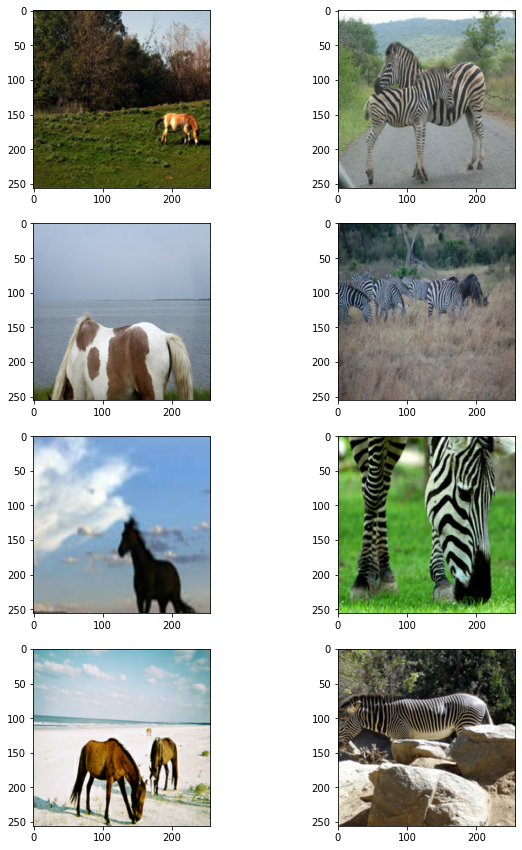

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_horses.take(4), train_zebras.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()

빌더 모델

In [ ]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(test_horses.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

1067/1067 [==============================] - 742s 652ms/step - G_loss: 4.4893 - F_loss: 4.1181 - D_X_loss: 0.1659 - D_Y_loss: 0.1121


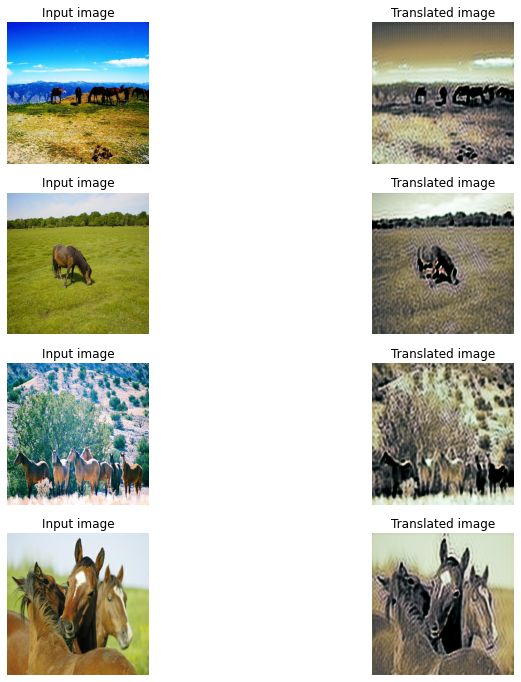

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_horses, train_zebras)),
    epochs=1,
    callbacks=[plotter, model_checkpoint_callback],
)

In [ ]:
!curl -LO https://github.com/AakashKumarNain/CycleGAN_TF2/releases/download/v1.0/saved_checkpoints.zip
!unzip -qq saved_checkpoints.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   647  100   647    0     0   5990      0 --:--:-- --:--:-- --:--:--  5990
100  273M  100  273M    0     0  66.9M      0  0:00:04  0:00:04 --:--:-- 74.7M


Weights loaded successfully


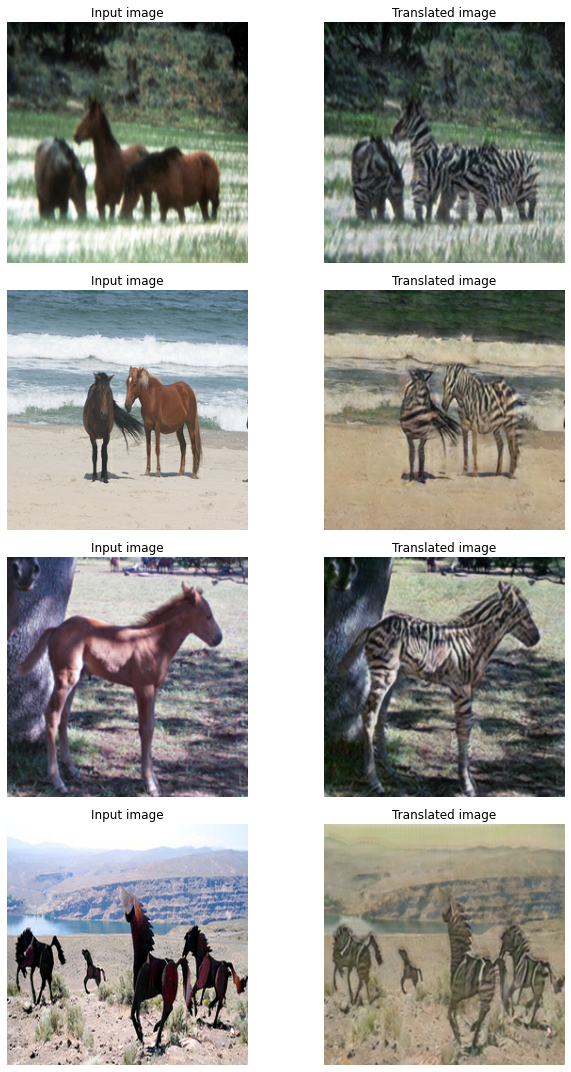

In [ ]:
# Load the checkpoints
weight_file = "./saved_checkpoints/cyclegan_checkpoints.090"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(test_horses.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

# remove

## Import and reuse the Pix2Pix models

다음에서 나오는 패키지를 통해서 [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) 에서 사용되는 모델을 가져옵니다. [tensorflow_examples](https://github.com/tensorflow/examples) package.

이번 예제에서 사용하는 모델은 [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py)에서 사용된 것과 유사하나, 몇가치 차이점이 있습니다.

* Cyclegan 에서는 [instance normalization](https://arxiv.org/abs/1607.08022) 을 [batch normalization](https://arxiv.org/abs/1502.03167) 대신에 사용합니다. 
* 이 논문 [CycleGAN paper](https://arxiv.org/abs/1703.10593) 개정된 `resnet` 기반의 생성모델을 사용합니다. 단순화를 위해 개정된 `unet` 생성기를 사용합니다.

2개의 생성기와 2개의 판별기가 각각 훈련됩니다. 

* 생성기 `G`는 이미지 `X`를 이미지 `Y`로 변환. $(G: X -> Y)$
* 생성기 `F`는 이미지 `Y`를 이미지 `X`. $(F: Y -> X)$
* 판별기 `D_X`는 이미지 `X` 와 생성된 이미지 `X` (`F(Y)`)를 구별.
* 판별기 `D_Y`는 이미지 `Y` 와 생성된 이미지 `Y` (`G(X)`)를 구별하는 것을 학습합니다.

![Cyclegan model](https://www.tensorflow.org/tutorials/generative/images/cyclegan_model.png)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

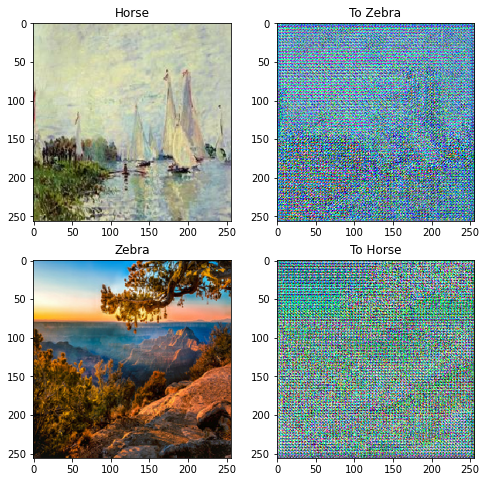

In [ ]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

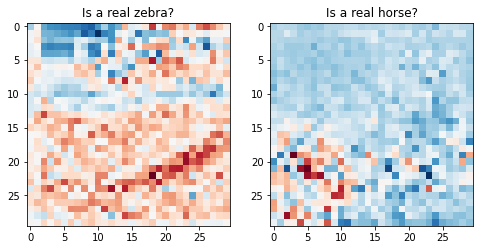

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 손실함수

CycleGAN에서는 학습 할 쌍 데이터가 없으므로 입력 x 및 대상 y 쌍이 학습 중에 의미가 있다는 보장이 없습니다. <br> 따라서 네트워크가 올바른 매핑을 학습하도록하기 위해 저자는주기 일관성 손실을 제안합니다.
<br>판별 기 손실과 생성기 손실은 pix2pix 에서 사용되는 것과 유사합니다

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

주기 일관성은 결과가 원래 입력에 가까워 야 함을 의미합니다. <br>예를 들어, 한 문장을 영어에서 프랑스어로 번역 한 다음 다시 프랑스어에서 영어로 번역하는 경우 결과 문장은 원래 문장과 동일해야합니다.

Cycle의 특징: 일관성 손실<br>
- $X$ 이미지는 생성 된 $\hat{Y}$ 이미지를 생성하는 $G$ 생성기를 통해 전달됩니다.
- 생성 된 이미지 $\hat{Y}$는 순환 이미지 $\hat{X}$을 생성하는 생성기 $F$를 통해 전달됩니다.
- 평균 절대 오차는 $X$와 $\hat{X}$ 사이에서 계산됩니다.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://www.tensorflow.org/tutorials/generative/images/cycle_loss.png)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

위와 같이 $G$생성기는 $X$이미지를 $Y$이미지로 변환합니다. <br>
ID 손실은 $Y$이미지를 생성기 $G$에 공급하면 실제 이미지 $Y$ 또는 $Y$ 에 가까운 이미지를 생성해야한다고 말합니다.

말에서 zebra-to-horse 모델을 실행하거나 얼룩말에서 horse-to-zebra 모델을 실행하는 경우 이미지에 이미 대상 클래스가 포함되어 있으므로 이미지를 많이 수정해서는 안됩니다.


$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

모든 생성기와 판별기에 대한 최적화 프로그램을 초기화합니다.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training
참고) 이 예제 모델은 실제 (200)보다 적은 에폭(40)에 대해 교육되어 이 자습서에 대한 교육 시간을 합리적으로 유지합니다. 예측이 정확하지 않을 수 있습니다. GPU가 허락 된다면, 넉넉히 돌려보시는 것을 추천합니다. (실제 제 GPU는 17번만에 뻗어서... 출력이미지가 그렇게 좋지 않습니다.)

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

훈련 루프가 복잡해 보이지만 네 가지 기본 단계로 구성됩니다.

- 예측 값을 가져옵니다.
- 손실을 계산하고,
- 역 전파를 사용하여 기울기를 계산합니다.
- 최적화기에 그라디언트를 적용하여 업데이트 합니다.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
# for image_x, image_y in tf.data.Dataset.zip((train_A, train_B)):
#   #image_x.type
#   print(image_x.shape)

AttributeError: ignored

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_A, train_B)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

ValueError: ignored

## 테스트 데이터 세트를 활용하여 이미지 생성

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

# Review

- GAN의 개념을 설명할 수 있다.
- GAN에서 생성자와 판별자의 공통된 모듈이 어디에 있는 지 파악할 수 있다.
- 학습된 CheckPoint 저장하고, 불러올 수 있다.
- 생성한 이미지를 gif형태로 제작할 수 있다.

이 외의 다른 종류의 GAN들은 이름만 소개하도록 하겠습니다. 
- Least Squares GAN : LSGAN
- Semi-Supervised GAN : SSGAN, Class 분류와 동시에 진위여부를 확인하는 GAN
- Auxiliary Classifier GAN : Class, noise를 이용하여 만들어내는 GAN
- Stack GAN : Text를 이용해서 이미지를 생성하는 GAN
- **Cycle GAN : 그림을 사진으로, 사진을 그림으로, 말을 얼룩말로 얼룩말을 말로!!**
- Disco GAN : Cycle GAN과 유사, 가방에 신발 디자인을 반영하는 Cross Modality GAN
- Design GAN : 새로운 디자인 티셔츠를 만들기
- Style GAN : 1024x1024 고화질의 이미지를 만들어내는 GAN
- Adapitve instance normalizaton : AdaIN - Style transfer

<img src="https://www.cs.cornell.edu/~xhuang/img/adain.jpg"/>

# reference

- https://www.tensorflow.org/tutorials/generative
- https://arxiv.org/abs/1703.10593
- https://www.tensorflow.org/tutorials/generative/pix2pix
- https://arxiv.org/pdf/1511.06434.pdf
- http://introtodeeplearning.com/
- 고화질 이미지를 제작하는 [Style GAN](https://www.youtube.com/watch?v=TWzEbMrH59o)
- GAN을 평가하는 [지표](https://m.blog.naver.com/chrhdhkd/222013835684)